In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np


In [2]:
DATASET_PATH = "../hsrp_dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH + "/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)


Found 505 files belonging to 2 classes.
Found 109 files belonging to 2 classes.
Found 109 files belonging to 2 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)


In [5]:
base_model = MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze base model


4334752/4334752 [==============================] - 0s 0us/step


In [6]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 576)               2304      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/15
16/16 [==============================] - 12s 405ms/step - loss: 0.8525 - accuracy: 0.5149 - val_loss: 0.6486 - val_accuracy: 0.6055
Epoch 2/15
16/16 [==============================] - 5s 327ms/step - loss: 0.6146 - accuracy: 0.6851 - val_loss: 0.5901 - val_accuracy: 0.7339
Epoch 3/15
16/16 [==============================] - 5s 327ms/step - loss: 0.5036 - accuracy: 0.7644 - val_loss: 0.5722 - val_accuracy: 0.7064
Epoch 4/15
16/16 [==============================] - 5s 293ms/step - loss: 0.4133 - accuracy: 0.8238 - val_loss: 0.5683 - val_accuracy: 0.7156
Epoch 5/15
16/16 [==============================] - 6s 376ms/step - loss: 0.3726 - accuracy: 0.8396 - val_loss: 0.5664 - val_accuracy: 0.7156
Epoch 6/15
16/16 [==============================] - 6s 333ms/step - loss: 0.3107 - accuracy: 0.8772 - val_loss: 0.5670 - val_accuracy: 0.7248
Epoch 7/15
16/16 [==============================] - 5s 307ms/step - loss: 0.2894 - accuracy: 0.8832 - val_loss: 0.5662 - val_accuracy: 0.7248
Epoch

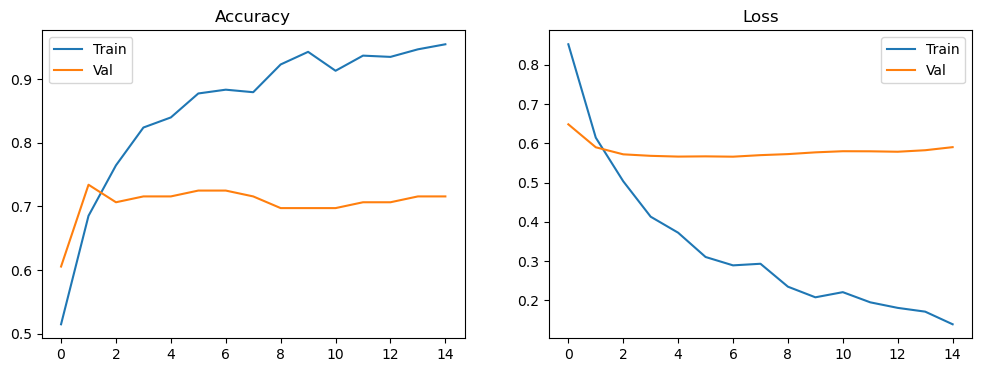

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()


In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")


4/4 [==============================] - 1s 215ms/step - loss: 0.3086 - accuracy: 0.8532
Test Accuracy: 85.32%


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Non-HSRP", "HSRP"]))


4/4 [==============================] - 2s 202ms/step
Confusion Matrix:
 [[56  3]
 [13 37]]

Classification Report:

              precision    recall  f1-score   support

    Non-HSRP       0.81      0.95      0.87        59
        HSRP       0.93      0.74      0.82        50

    accuracy                           0.85       109
   macro avg       0.87      0.84      0.85       109
weighted avg       0.86      0.85      0.85       109



In [12]:
model.save("hsrp_mobilenetv3_model.h5")


C:\Users\pushk\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
